<a href="https://colab.research.google.com/github/Gr-30/DL/blob/main/Assign4_Q2_Twitter_114_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import Libraries/Dataset

## a. Import the required libraries and the dataset.

In [2]:
import os
seed=21
os.environ['PYTHONHASHSEED']=str(seed)
import copy
import time
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
import tensorflow.keras.regularizers as reg
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")

def reset_random_seeds(seed_val):
    os.environ['PYTHONHASHSEED']=str(seed_val)
    tf.random.set_seed(seed_val)
    np.random.seed(seed_val)

reset_random_seeds(seed)

## b. Check the GPU available

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-778ca916-2346-7ec0-6f00-2e46c5e7d9c6)


# Data Visualization

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Mtech DSE BITS/Sem3/DL/Assignment1/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python", header=None)
 # As the data has no column titles, we will add our own
data.columns = ["label", "time", "date", "query", "username", "text"]

## a. Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text.

In [80]:
df_pos = data[data['label'] == 1.0]
df_neg = data[data['label'] == 0.0]

In [82]:
print('POSITIVE Label data ')
print(df_pos.head())

POSITIVE Label data 
                                                     text  label
800000       I LOVE @Health4UandPets u guys r the best!!       1
800001  im meeting up with one of my besties tonight! ...      1
800002  @DaRealSunisaKim Thanks for the Twitter add, S...      1
800003  Being sick can be really cheap when it hurts t...      1
800004    @LovesBrooklyn2 he has that effect on everyone       1


In [75]:
print('Negative Label data ')
print(df_neg.head())

Negative Label data 


,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#### Five top records of data

In [8]:
data.head()

,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#### Five last records of data

In [9]:
data.tail()

,label,time,date,query,username,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


#### Coloumns/features in data

In [10]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [11]:
data['label'].value_counts()

4    800000
0    800000
Name: label, dtype: int64

#### Length of data

In [12]:
print('lenght of data is', len(data))

lenght of data is 1600000


#### Shape of data

In [13]:
data.shape

(1600000, 6)

#### Data information

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1600000 non-null  int64 
 1   time      1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   username  1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#### Data types of all coloumns

In [15]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

#### Checking Null values

In [16]:
np.sum(data.isnull().any(axis=1))

0

#### Rows and columns in the dataset

In [17]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   6


In [18]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   1600000


In [19]:
data=data[['text','label']]

## b. Plot a bar graph of class distribution in a dataset. Each bar depicts the number of tweets belonging to a particular sentiment.

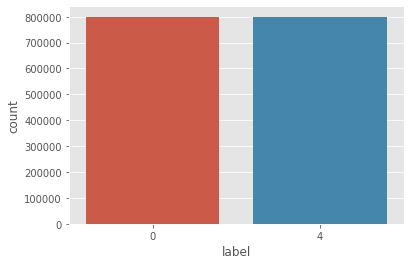

In [20]:
datag = data.groupby('label').size().reset_index(name='count')
sns.barplot(y="count",x="label", data=datag)


## c. Other visualizations

In [21]:
stopwords_ = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        collocations=False,
        background_color='white',
        stopwords=stopwords_,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

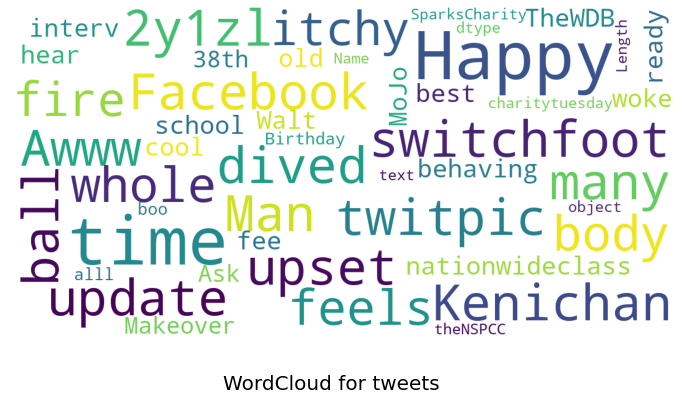

In [22]:
show_wordcloud(data['text'], "WordCloud for tweets")

# Data Pre-processing
a. Need for this Step-Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step. The discussion of different ways of handling this step is out of the scope of this assignment.

b. Please use this pre-trained embedding layerfrom TensorFlow hub for this assignment. This link also has a code snippet on how to convert a sentence to a vector. Refer to that for further clarity on this subject.

c. Bring the train and test data in the required format.

## Assigning 1 to Positive sentment 4

In [23]:
data['label'][data['label']==4]=1

##  Separating input feature and label

In [24]:
X=data.text
y=data.label

### c. Bring the train and test data in the required format.

#### Separating the 80% data for training data and 20% for testing data
As we prepared all the tweets, now we are separating/splitting the tweets into training data and testing data.
- 80% tweets will be used in the training 
- 20% tweets will be used to test the performance of the model.

In [25]:
X_train_org, X_test_org, Y_train, Y_test = train_test_split(data, y, test_size=0.2, random_state=2)
X_train_org, X_val_org, Y_train, Y_val = train_test_split(X_train_org, Y_train, test_size=0.2, random_state=3)

### b. Please use this pre-trained embedding layer from TensorFlow hub for this assignment. 

In [26]:
X_train = embed(X_train_org.text.values).numpy()
X_val = embed(X_val_org.text.values).numpy()
X_test = embed(X_test_org.text.values).numpy()

# Data Visualization

## d. Print the shapes of train and test data.

In [27]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('Y_train: ', Y_train.shape)
print('Y_test: ', Y_test.shape)

X_train:  (1024000, 128)
X_test:  (320000, 128)
Y_train:  (1024000,)
Y_test:  (320000,)


# Model Building
a. Sequential Model layers-Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons. : **To prepare near best model we gradually decrease number of neurons in hidden layers by dividing the number of neurons in the previous layers by 2. Hence when we start at 64 neurons and have to prepare 2 more layers then one option would be 32 followed by 16**

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.d.Choose the appropriate activation function for all the layers.e.Print the model summary.

In [28]:
def model_base(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=(128))
    layer = Dropout(0.1, name='dropout')(inputs)
    layer = Dense(64,name='layer1', activation='relu',kernel_regularizer=reg.L2(0.0005))(layer)
    layer = Dense(32,name='layer2', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(16,name='layer3', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(1,name='output', activation='sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1,mode='auto', baseline=None, restore_best_weights=False
)

## e. Print the model summary

In [29]:
model = model_base() # here we are calling the function of created model
print('Model summary')
model.summary() 

Model summary
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                8256      
_________________________________________________________________
layer2 (Dense)               (None, 32)                2080      
_________________________________________________________________
layer3 (Dense)               (None, 16)                528       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 10,881
Trainable params: 10,881
Non-trainable params: 0
___________________________________________

# Model Compilation
a.Compile the model with the appropriate loss function.

b.Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.: **We intially choose 0.001(least possible) but later realised that the training is too slow and could be improved without compromising the accuracy of the model so changed the learning rate to 0.005.**

c.Use accuracy as a metric.

In [30]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.005),metrics=['accuracy']) 

# Model Training
a. Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [31]:
startTime = time.time()
history=model.fit(X_train,Y_train,batch_size=128,epochs=100, validation_data=(X_val, Y_val), callbacks=[callback])# here we are starting the training of model by feeding the training data
endTime = time.time()
print('Training finished in : {}s'.format(round(endTime - startTime, 2)))

Epoch 1/100
8000/8000 [==============================] - 21s 3ms/step - loss: 0.5992 - accuracy: 0.6906 - val_loss: 0.5778 - val_accuracy: 0.7046
Epoch 2/100
8000/8000 [==============================] - 20s 2ms/step - loss: 0.5858 - accuracy: 0.6989 - val_loss: 0.5719 - val_accuracy: 0.7117
Epoch 3/100
8000/8000 [==============================] - 20s 2ms/step - loss: 0.5858 - accuracy: 0.6989 - val_loss: 0.5739 - val_accuracy: 0.7086
Epoch 4/100
8000/8000 [==============================] - 20s 2ms/step - loss: 0.5843 - accuracy: 0.6987 - val_loss: 0.5707 - val_accuracy: 0.7109
Epoch 5/100
8000/8000 [==============================] - 20s 2ms/step - loss: 0.5859 - accuracy: 0.6978 - val_loss: 0.5937 - val_accuracy: 0.6921
Epoch 6/100
8000/8000 [==============================] - 20s 2ms/step - loss: 0.5852 - accuracy: 0.6989 - val_loss: 0.5714 - val_accuracy: 0.7125
Epoch 7/100
8000/8000 [==============================] - 20s 2ms/step - loss: 0.5841 - accuracy: 0.6998 - val_loss: 0.5800 -

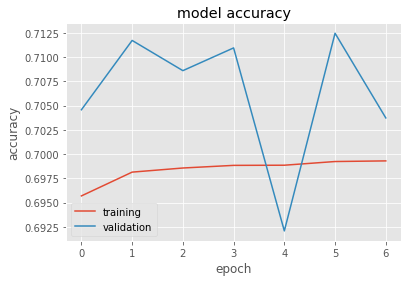

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

{'loss': [0.5911034345626831, 0.5859808921813965, 0.5856017470359802, 0.5847506523132324, 0.5853444337844849, 0.584743857383728, 0.5844801068305969], 'accuracy': [0.6956943273544312, 0.6981464624404907, 0.6985703110694885, 0.6988418102264404, 0.698858380317688, 0.6992383003234863, 0.6993036866188049], 'val_loss': [0.577846109867096, 0.5719144940376282, 0.5739306807518005, 0.570665180683136, 0.5936640501022339, 0.5713658928871155, 0.5800479054450989], 'val_accuracy': [0.7045742273330688, 0.711718738079071, 0.7086054682731628, 0.7109492421150208, 0.6920859217643738, 0.7124609351158142, 0.7037343978881836]}


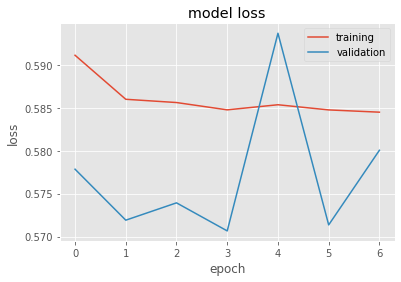

In [33]:
print(history.history)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

# Model Evaluation

a.Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b.Print the two most incorrectly classified texts for each class in the test dataset.

In [34]:
accr1 = model.evaluate(X_val,Y_val) #we are starting to test the model here

8000/8000 [==============================] - 14s 2ms/step - loss: 0.5800 - accuracy: 0.7037


In [35]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.70


In [36]:
y_pred = model.predict(X_val) #getting predictions on the trained model
y_pred_class = (y_pred > 0.5)

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.60      0.67    127978
           1       0.67      0.81      0.73    128022

    accuracy                           0.70    256000
   macro avg       0.71      0.70      0.70    256000
weighted avg       0.71      0.70      0.70    256000

Confusion matrix
[[ 77067  50911]
 [ 24933 103089]]


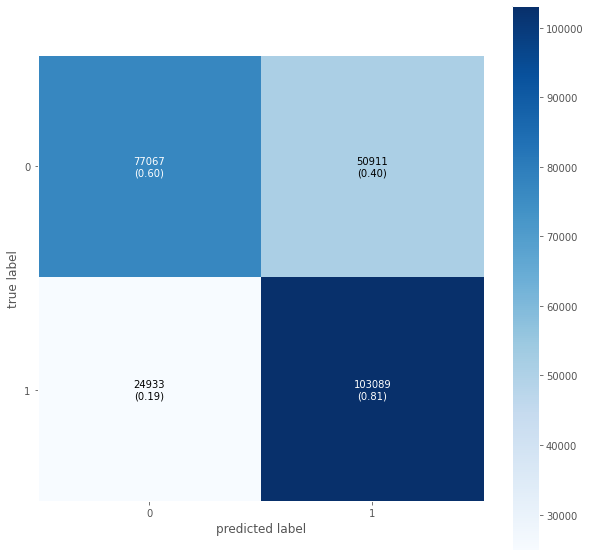

In [39]:
print('Classification Report')
print(classification_report(Y_val, y_pred_class))
print("Confusion matrix")
CR=confusion_matrix(Y_val, y_pred_class)
print(CR)
fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### a.Negative class or Negative Sentiment is slightly better performing as per the confusion matrix.

#### ROC CURVE

In [40]:
print(roc_auc_score(Y_val, y_pred_class))

0.7037169249633175


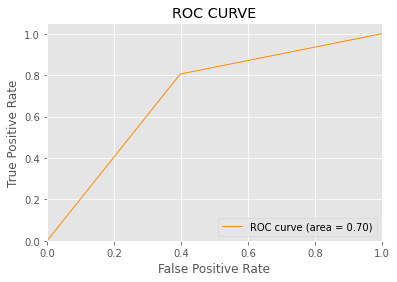

In [41]:
fpr, tpr, thresholds = roc_curve(Y_val, y_pred_class)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()
print()

### b.Print the two most incorrectly classified texts for each class in the test dataset.

In [42]:
def find_2_smallest_index(arr):
    first = 999
    second = 999
    first_index=0
    sexond_index=0
    for i in range(len(arr)):
        if arr[i] < first:
            second = copy.deepcopy(first)
            second_index = copy.deepcopy(first_index)
            first = copy.deepcopy(arr[i])
            first_index = copy.deepcopy(i)
        elif (arr[i] < second):
            second = copy.deepcopy(arr[i])
            second_index = copy.deepcopy(i)
    return first_index, second_index

In [43]:
worst_2 = {}
y_pred_test = model.predict(X_test)
first_index, second_index = find_2_smallest_index(1-y_pred_test[:])
worst_2[0] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
first_index, second_index = find_2_smallest_index(y_pred_test[:])
worst_2[1] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
worst_2

{0: ['#BTS is fallin!!   #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS',
  '@allenbrand Happy Birthday to you! Happy Birthday to you! Happy Birthday dear Allen! Happy Birthday to you! And many moooore! '],
 1: ['bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad day. ',
  'headache headache headache ']}

# Hyperparameter Tuning
Build two more additional models by changing the following hyperparameters ONE at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.
1. Batch Size: Change the value of batch size in model training
2. Dropout: Change the position and value of dropout layer
Write a comparison between each model and give reasons for the difference in results.

### **1.Batch Size: Change the value of batch size in model training**

# Model Building
a. Sequential Model layers-Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons. : **To prepare near best model we gradually decrease number of neurons in hidden layers by dividing the number of neurons in the previous layers by 2. Hence when we start at 64 neurons and have to prepare 3 more layers then one option would be 32 followed by 16 followed by 8**

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.d.Choose the appropriate activation function for all the layers.e.Print the model summary.

In [44]:
def model_hyp1(): #Defined tensorflow_based_model function for training tensorflow based model
    inputs = Input(name='inputs',shape=(128))
    layer = Dropout(0.1, name='dropout')(inputs)
    layer = Dense(64,name='layer1', activation='relu',kernel_regularizer=reg.L2(0.0005))(layer)
    layer = Dense(32,name='layer2', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(16,name='layer3', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(8,name='layer4', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer)
    layer = Dense(1,name='output', activation='sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1,mode='auto', baseline=None, restore_best_weights=False
)

## e. Print the model summary

In [45]:
model = model_hyp1() # here we are calling the function of created model
print('Model summary')
model.summary()

Model summary
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                8256      
_________________________________________________________________
layer2 (Dense)               (None, 32)                2080      
_________________________________________________________________
layer3 (Dense)               (None, 16)                528       
_________________________________________________________________
layer4 (Dense)               (None, 8)                 136       
_________________________________________________________________
output (Dense)               (None, 1)       

# Model Compilation
a.Compile the model with the appropriate loss function.

b.Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.: **We intially choose 0.001(least possible) but later realised that the training is too slow and could be improved without compromising the accuracy of the model so changed the learning rate to 0.005.**

c.Use accuracy as a metric.

In [46]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.005),metrics=['accuracy']) 

# Model Training
a. Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [47]:
startTime = time.time()
history=model.fit(X_train,Y_train,batch_size=128,epochs=100, validation_split=0.2, callbacks=[callback])# here we are starting the training of model by feeding the training data
endTime = time.time()
print('Training finished in : {}s'.format(round(endTime - startTime, 2)))

Epoch 1/100
6400/6400 [==============================] - 18s 3ms/step - loss: 0.6044 - accuracy: 0.6895 - val_loss: 0.5757 - val_accuracy: 0.7119
Epoch 2/100
6400/6400 [==============================] - 17s 3ms/step - loss: 0.5890 - accuracy: 0.6977 - val_loss: 0.5731 - val_accuracy: 0.7107
Epoch 3/100
6400/6400 [==============================] - 17s 3ms/step - loss: 0.5861 - accuracy: 0.7001 - val_loss: 0.5815 - val_accuracy: 0.7062
Epoch 4/100
6400/6400 [==============================] - 17s 3ms/step - loss: 0.5870 - accuracy: 0.6997 - val_loss: 0.5753 - val_accuracy: 0.7098
Epoch 5/100
6400/6400 [==============================] - 17s 3ms/step - loss: 0.5869 - accuracy: 0.6995 - val_loss: 0.5744 - val_accuracy: 0.7080
Epoch 00005: early stopping
Training finished in : 85.65s


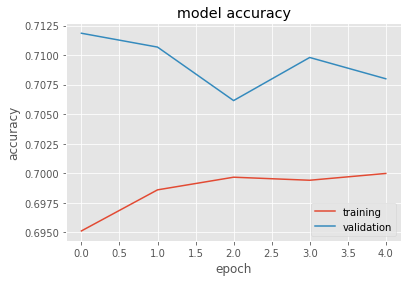

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

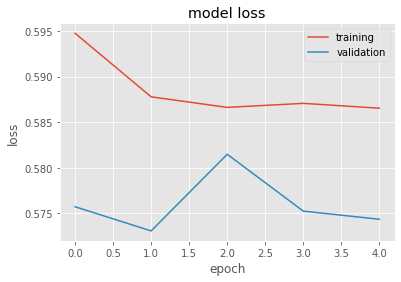

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

# Model Evaluation

a.Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b.Print the two most incorrectly classified texts for each class in the test dataset.

In [50]:
accr1 = model.evaluate(X_val,Y_val) #we are starting to test the model here

8000/8000 [==============================] - 14s 2ms/step - loss: 0.5728 - accuracy: 0.7100


In [51]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.71


In [52]:
y_pred = model.predict(X_val) #getting predictions on the trained model
y_pred_class = (y_pred > 0.5)

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.66      0.69    127978
           1       0.69      0.76      0.72    128022

    accuracy                           0.71    256000
   macro avg       0.71      0.71      0.71    256000
weighted avg       0.71      0.71      0.71    256000

Confusion matrix
[[84194 43784]
 [30464 97558]]


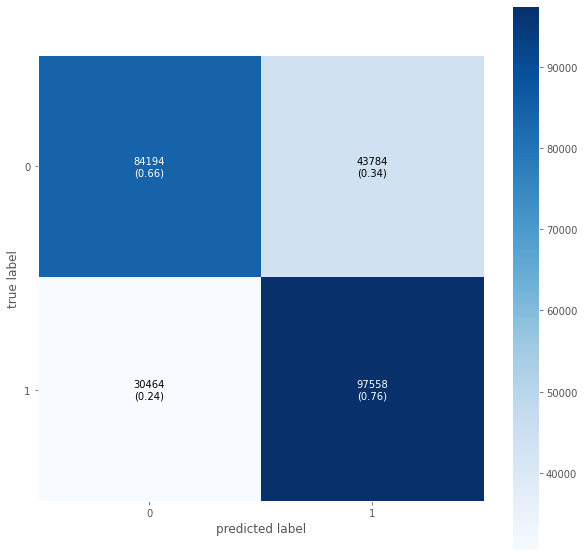

In [54]:
print('Classification Report')
print(classification_report(Y_val, y_pred_class))
print("Confusion matrix")
CR=confusion_matrix(Y_val, y_pred_class)
print(CR)
fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### a.Negative class or Negative Sentiment is slightly better performing as per the confusion matrix.

#### ROC CURVE

In [55]:
print(roc_auc_score(Y_val, y_pred_class))

0.7099597985608241


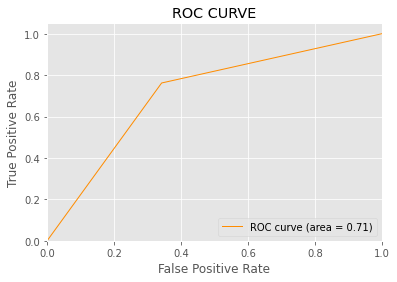

In [56]:
fpr, tpr, thresholds = roc_curve(Y_val, y_pred_class)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()
print()

### b.Print the two most incorrectly classified texts for each class in the test dataset.

In [57]:
def find_2_smallest_index(arr):
    first = 999
    second = 999
    first_index=0
    sexond_index=0
    for i in range(len(arr)):
        if arr[i] < first:
            second = copy.deepcopy(first)
            second_index = copy.deepcopy(first_index)
            first = copy.deepcopy(arr[i])
            first_index = copy.deepcopy(i)
        elif (arr[i] < second):
            second = copy.deepcopy(arr[i])
            second_index = copy.deepcopy(i)
    return first_index, second_index

In [58]:
worst_2 = {}
y_pred_test = model.predict(X_test)
first_index, second_index = find_2_smallest_index(1-y_pred_test[:])
worst_2[0] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
first_index, second_index = find_2_smallest_index(y_pred_test[:])
worst_2[1] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
worst_2

{0: ['great day, great weather, great place, great movie, great food, great people ',
  'Good Night Twitter World, Good Night Friends, Good Night Family, Good Night my Love, and Good Night Jesus! '],
 1: ['bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad day. ',
  'ugh ugh ugh ugh ugh ugh ugh ugh ugh ugh ugh ugh ugh ugh ugh ugh ugh ugh          ']}

### **2.Optimiser: Use a different optimizer with the appropriate LR value**

# Model Building
a. Sequential Model layers-Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons. : **To prepare near best model we gradually decrease number of neurons in hidden layers by dividing the number of neurons in the previous layers by 2. Hence when we start at 64 neurons and have to prepare 2 more layers then one option would be 32 followed by 16**

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.d.Choose the appropriate activation function for all the layers.e.Print the model summary.

In [59]:
def model_hyp2(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=(128))
    layer = Dropout(0.1, name='dropout')(inputs)
    layer = Dense(64,name='layer1', activation='relu',kernel_regularizer=reg.L2(0.0005))(inputs)
    layer = Dense(32,name='layer2', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(16,name='layer3', activation='relu', kernel_regularizer=reg.L2(0.0005))(layer) 
    layer = Dense(1,name='output', activation='sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1,mode='auto', baseline=None, restore_best_weights=False
)

## e. Print the model summary

In [60]:
model = model_hyp1() # here we are calling the function of created model
print('Model summary')
model.summary()

Model summary
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                8256      
_________________________________________________________________
layer2 (Dense)               (None, 32)                2080      
_________________________________________________________________
layer3 (Dense)               (None, 16)                528       
_________________________________________________________________
layer4 (Dense)               (None, 8)                 136       
_________________________________________________________________
output (Dense)               (None, 1)       

# Model Compilation
a.Compile the model with the appropriate loss function.

b.Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.: **We chose adam optimizer to incorporate the momentum component in the optimization process. We intially choose 0.001(least possible) but later realised that the training is too slow and could be improved without compromising the accuracy of the model so changed the learning rate to 0.005.**

c.Use accuracy as a metric.

In [61]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.005),metrics=['accuracy']) 

# Model Training
a. Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [62]:
startTime = time.time()
history=model.fit(X_train,Y_train,batch_size=128,epochs=100, validation_split=0.2, callbacks=[callback])# here we are starting the training of model by feeding the training data
endTime = time.time()
print('Training finished in : {}s'.format(round(endTime - startTime, 2)))

Epoch 1/100
6400/6400 [==============================] - 16s 2ms/step - loss: 0.6042 - accuracy: 0.6896 - val_loss: 0.5771 - val_accuracy: 0.7095
Epoch 2/100
6400/6400 [==============================] - 15s 2ms/step - loss: 0.5877 - accuracy: 0.6992 - val_loss: 0.5778 - val_accuracy: 0.7071
Epoch 3/100
6400/6400 [==============================] - 15s 2ms/step - loss: 0.5848 - accuracy: 0.7005 - val_loss: 0.5735 - val_accuracy: 0.7098
Epoch 4/100
6400/6400 [==============================] - 15s 2ms/step - loss: 0.5851 - accuracy: 0.7004 - val_loss: 0.5750 - val_accuracy: 0.7088
Epoch 5/100
6400/6400 [==============================] - 15s 2ms/step - loss: 0.5851 - accuracy: 0.6990 - val_loss: 0.5747 - val_accuracy: 0.7087
Epoch 6/100
6400/6400 [==============================] - 15s 2ms/step - loss: 0.5835 - accuracy: 0.7008 - val_loss: 0.5734 - val_accuracy: 0.7106
Epoch 00006: early stopping
Training finished in : 89.7s


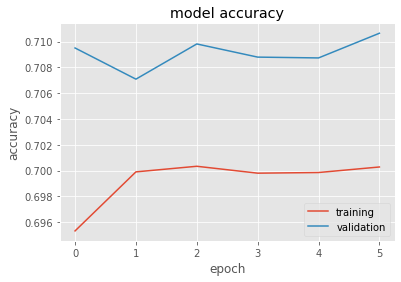

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

{'loss': [0.5941046476364136, 0.5864654779434204, 0.5849900841712952, 0.5852028131484985, 0.584679126739502, 0.5842084884643555], 'accuracy': [0.6953222751617432, 0.6998999118804932, 0.7003344893455505, 0.6997997760772705, 0.6998498439788818, 0.7002795338630676], 'val_loss': [0.5770757794380188, 0.5777691602706909, 0.5734870433807373, 0.5749700665473938, 0.5747063159942627, 0.5733942985534668], 'val_accuracy': [0.7095068097114563, 0.7070898413658142, 0.7098193168640137, 0.7087988257408142, 0.7087353467941284, 0.7106494307518005]}


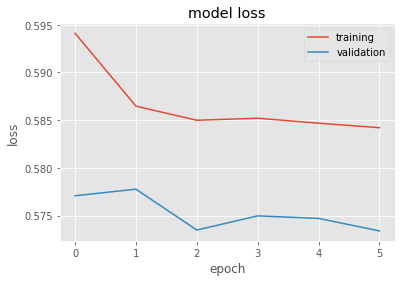

In [64]:
print(history.history)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

# Model Evaluation

a.Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b.Print the two most incorrectly classified texts for each class in the test dataset.

In [65]:
accr1 = model.evaluate(X_val,Y_val) #we are starting to test the model here

8000/8000 [==============================] - 14s 2ms/step - loss: 0.5727 - accuracy: 0.7113


In [66]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.71


In [67]:
y_pred = model.predict(X_val) #getting predictions on the trained model
y_pred_class = (y_pred > 0.5)

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.70      0.71    127978
           1       0.71      0.73      0.72    128022

    accuracy                           0.71    256000
   macro avg       0.71      0.71      0.71    256000
weighted avg       0.71      0.71      0.71    256000

Confusion matrix
[[89085 38893]
 [35027 92995]]


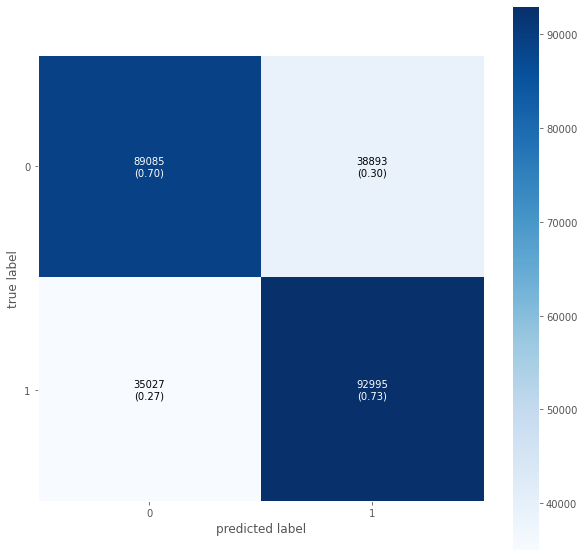

In [68]:
print('Classification Report')
print(classification_report(Y_val, y_pred_class))
print("Confusion matrix")
CR=confusion_matrix(Y_val, y_pred_class)
print(CR)
fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### a.Negative class or Negative Sentiment is slightly better performing as per the confusion matrix.

#### ROC CURVE

In [69]:
print(roc_auc_score(Y_val, y_pred_class))

0.7112473958889001


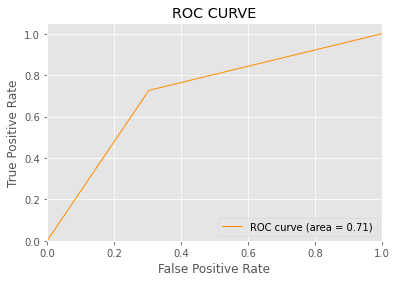

In [70]:
fpr, tpr, thresholds = roc_curve(Y_val, y_pred_class)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()
print()

### b.Print the two most incorrectly classified texts for each class in the test dataset.

In [71]:
def find_2_smallest_index(arr):
    first = 999
    second = 999
    first_index=0
    sexond_index=0
    for i in range(len(arr)):
        if arr[i] < first:
            second = copy.deepcopy(first)
            second_index = copy.deepcopy(first_index)
            first = copy.deepcopy(arr[i])
            first_index = copy.deepcopy(i)
        elif (arr[i] < second):
            second = copy.deepcopy(arr[i])
            second_index = copy.deepcopy(i)
    return first_index, second_index

In [72]:
worst_2 = {}
y_pred_test = model.predict(X_test)
first_index, second_index = find_2_smallest_index(1-y_pred_test[:])
worst_2[0] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
first_index, second_index = find_2_smallest_index(y_pred_test[:])
worst_2[1] = [X_test_org.text.values[first_index],X_test_org.text.values[second_index]]
worst_2

{0: ['#BTS is fallin!!   #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS #BTS',
  'Good Night Twitter World, Good Night Friends, Good Night Family, Good Night my Love, and Good Night Jesus! '],
 1: ['bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad day. ',
  'headache headache headache ']}

# Write a comparison between each model and give reasons for the difference in results.